## Project Title: Prediction of Forest Cover Type

### Author - Renjini Ramadasan Nair


## Introduction

Source of the data: The UCI machine learning repository (url: https://archive.ics.uci.edu/ml/datasets/Covertype)

Original sources: <br>
    Original owners of database: 
	Remote Sensing and GIS Program, 
	Department of Forest Sciences, 
	College of Natural Resources, 
	Colorado State University, 
	Fort Collins, CO  80523
	(contact Jock A. Blackard, jblackard 'at' fs.fed.us or Dr. Denis J. Dean, denis.dean 'at' utdallas.edu)

The data for forest cover type determination was downloaded from the url (https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz). The data was comprised of cartographic variables, derived from data originally obtained from US Geological Survey (USGS) and USFS data. The actual cover type for each observation was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. <br>

There were 581012 rows and 55 columns. The columns represented the the following attributes: 
    Elevation (meters), 
    Aspect (azimuth), 
    Slope (degrees), 
    Horizontal_Distance_To_Hydrology (meters), 
    Vertical_Distance_To_Hydrology (meters), 
    Horizontal_Distance_To_Roadways (meters), 
    Hillshade_9am (0 to 255 index), 
    Hillshade_Noon (0 to 255 index), 
    Hillshade_3pm (0 to 255 index), 
    Horizontal_Distance_To_Fire_Points (meters), 
    Wilderness_Area (4 binary columns), 
    Soil_Type (40 binary columns), 
    Cover_Type (7 types).

The final task is to build a predictive machine learning model that can reliably predict the forest cover type from the provided cartographic variables. For optimizing the classifier model, the attribute 'Cover_Type', represents the muticlass forest cover type classification. The summary of the observations, resulting from the statistical data analyses and the predicitve modeling, is provided at the bottom of the notebook. 

In [1]:
# Load necessary libraries
import requests
import gzip
import pandas as pd
import numpy as np
import seaborn as sb
import scipy.stats as ss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Function to bin numerical columns
def bins(x, n): 
    BinWidth = (max(x) - min(x))/n
    bound1 = float('-inf')
    bound2 = min(x) + 1 * BinWidth
    bound3 = min(x) + 2 * BinWidth
    bound4 = float('inf')
    Binned = np.array([" "]*len(x)) 
    Binned[(bound1 < x) & (x <= bound2)] = 1 # Low
    Binned[(bound2 < x) & (x <= bound3)] = 2 # Med
    Binned[(bound3 < x) & (x  < bound4)] = 3 # High
    return Binned

In [3]:
# Location of dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"

In [4]:
# Gather the data
response = requests.get(url, stream = True)
decompressed_file = gzip.GzipFile(fileobj=response.raw)

In [5]:
# Load the data into a dataframe (takes a minute to load)
df1 = pd.read_csv(decompressed_file, sep=',', header = None)

In [6]:
# Add column names
df1.columns = ['elevation', 'aspect', 'slope', 'hdist_to_hydro', 'vdist_to_hydro', 'hdist_to_road', 'hillshade_9am', 'hillshade_noon', 'hillshade_3pm', 'hdist_to_fire', 'rawa', 'neota', 'comanche', 'cache', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 'cover_type']

In [7]:
df = df1.copy()

## Exploratory Data Analyses

In [8]:
# View the first few rows
df.head()

,elevation,aspect,slope,hdist_to_hydro,vdist_to_hydro,hdist_to_road,hillshade_9am,hillshade_noon,hillshade_3pm,hdist_to_fire,...,32,33,34,35,36,37,38,39,40,cover_type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [9]:
df.describe()

,elevation,aspect,slope,hdist_to_hydro,vdist_to_hydro,hdist_to_road,hillshade_9am,hillshade_noon,hillshade_3pm,hdist_to_fire,...,32,33,34,35,36,37,38,39,40,cover_type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


The summary statistics indicated that some attributes followed a more or less normal distribution like the 'elevation' and 'hillshade at 3pm', while some others followed skewed distributions like 'horizontal distance to hydrology' and 'horizontal distance to roadways'. These were confirmed by plotting histograms and q-q plots. 

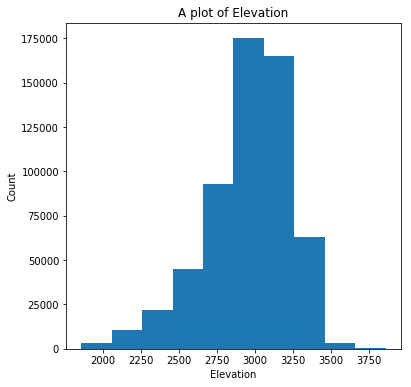

In [10]:
# Plot a histogram of the elevation
ax = plt.figure(figsize = (6, 6)).gca()
plt.hist(data = df, x = 'elevation')
ax.set_title('A plot of Elevation') # Give the plot a main title
ax.set_ylabel('Count')# Set text for y axis
ax.set_xlabel('Elevation');

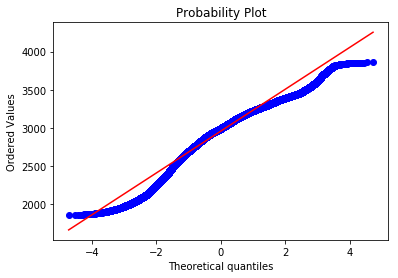

In [11]:
# Check whether elevation follows a normal distribution by q-q plot
ss.probplot(df['elevation'], plot = plt);

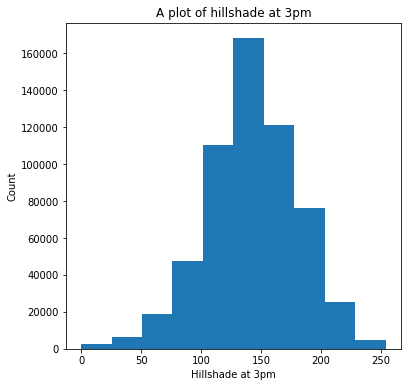

In [12]:
# Plot a histogram of hillshade at 3pm
ax = plt.figure(figsize = (6, 6)).gca()
plt.hist(data = df, x = 'hillshade_3pm')
ax.set_title('A plot of hillshade at 3pm') # Give the plot a main title
ax.set_ylabel('Count')# Set text for y axis
ax.set_xlabel('Hillshade at 3pm');

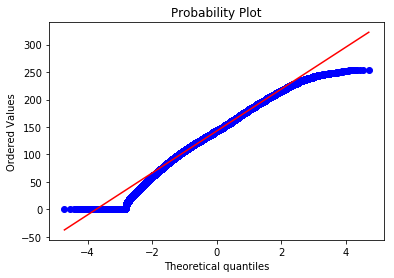

In [13]:
# Check whether hillshade at 3pm follows a normal distribution by q-q plot
ss.probplot(df['hillshade_3pm'], plot = plt);

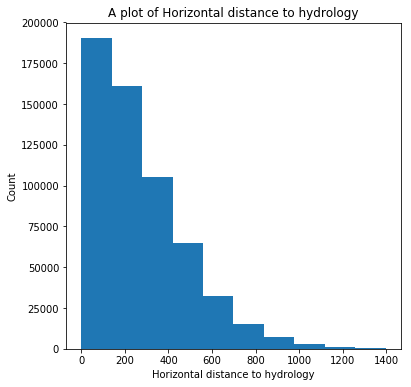

In [14]:
# Plot a histogram of hdist_to_hydro
ax = plt.figure(figsize = (6, 6)).gca()
plt.hist(data = df, x = 'hdist_to_hydro')
ax.set_title('A plot of Horizontal distance to hydrology') # Give the plot a main title
ax.set_ylabel('Count')# Set text for y axis
ax.set_xlabel('Horizontal distance to hydrology');

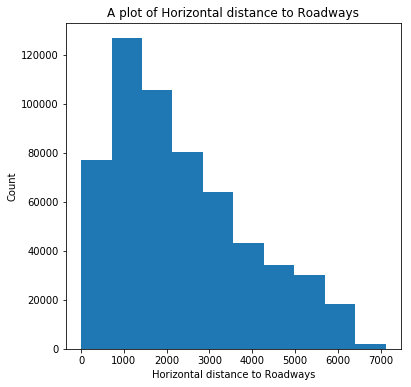

In [15]:
# Plot a histogram of hdist_to_road
ax = plt.figure(figsize = (6, 6)).gca()
plt.hist(data = df, x = 'hdist_to_road')
ax.set_title('A plot of Horizontal distance to Roadways') # Give the plot a main title
ax.set_ylabel('Count')# Set text for y axis
ax.set_xlabel('Horizontal distance to Roadways');

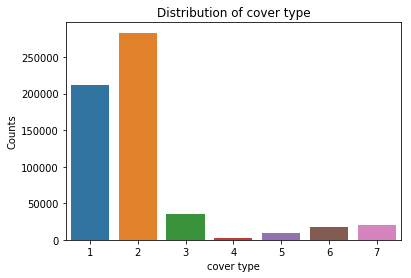

In [16]:
# Distribution of cover types
ax = sb.countplot(data = df, x = 'cover_type')
ax.set_title('Distribution of cover type') # Give the plot a main title
ax.set_ylabel('Counts')# Set text for y axis
ax.set_xlabel('cover type');

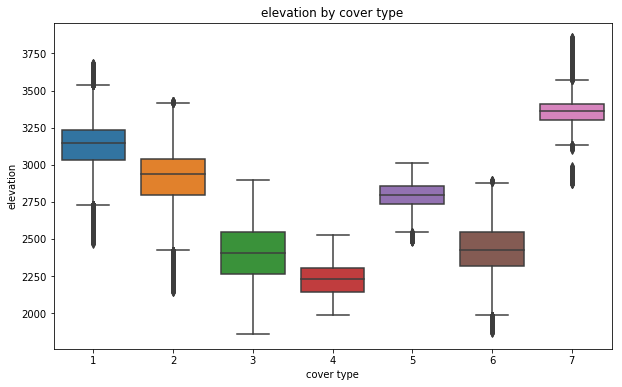

In [17]:
# Plot the elevation by cover type
ax = plt.figure(figsize = (10, 6)).gca()
sb.boxplot(data = df, x = 'cover_type', y = 'elevation', ax = ax)
ax.set_title('elevation by cover type') # Give the plot a main title
ax.set_ylabel('elevation')# Set text for y axis
ax.set_xlabel('cover type');

The cover types 1 and 2 seem most common, having 200,000 - 300,000 entries, while the rest (3-7) classes were constituted by less than 5000 instances each. Elevation seems to be a good variable at aiding classification of the cover types into groups, with some amount of overlaps between the classes. 

In [18]:
# Bin some of the numerical columns, hillshade_9am, vdist_to_hydro and hdist_to_road; drop obsolete columns
# hillshade_9am - Equal-width Binning using numpy
x = np.array(df['hillshade_9am'])
df['Binned_hillshade_9am'] = bins(x, 10)
df.drop('hillshade_9am', axis = 1, inplace = True)

# vdist_to_hydro - Equal-width Binning using numpy
x = np.array(df['vdist_to_hydro'])
df['Binned_vdist_to_hydro'] = bins(x, 6)
df.drop('vdist_to_hydro', axis = 1, inplace = True)

# hdist_to_road - Equal-width Binning using numpy
x = np.array(df['hdist_to_road'])
df['Binned_hdist_to_road'] = bins(x, 6)
df.drop('hdist_to_road', axis = 1, inplace = True)

In [19]:
# Change the datatype of binned columns to int
df['Binned_hillshade_9am'] = df['Binned_hillshade_9am'].astype('int', inplace = True)
df['Binned_vdist_to_hydro'] = df['Binned_vdist_to_hydro'].astype('int', inplace = True)
df['Binned_hdist_to_road'] = df['Binned_hdist_to_road'].astype('int', inplace = True)

In [20]:
# Specify the independent and dependent variables
X = df[['elevation', 'aspect', 'slope', 'hdist_to_hydro', 'Binned_vdist_to_hydro', 'Binned_hdist_to_road', 'Binned_hillshade_9am', 'hillshade_noon', 'hillshade_3pm', 'hdist_to_fire', 'rawa', 'neota', 'comanche', 'cache', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]]
Y = df['cover_type']

In [21]:
# Specifying model training on 80% of the data, by using a test-size of 20%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20)

In [32]:
# Classification by Logistic Regression (warning - takes a few minutes)
clf = LogisticRegression(solver = 'liblinear')
clf.fit(X_train, Y_train)
Y_predslr = clf.predict(X_test)
# Confusion matrix
confusion_matrix(Y_test, Y_predslr)

array([[29249, 12489,    34,     0,     2,     0,   742],
       [ 9924, 45175,  1327,     1,     4,    71,    60],
       [    0,   766,  6099,    46,     0,   145,     0],
       [    0,     0,   347,   125,     0,    50,     0],
       [   28,  1707,   174,     0,     1,     3,     0],
       [    2,  1291,  1977,     5,     0,   191,     0],
       [ 2045,    35,    12,     0,     0,     0,  2076]])

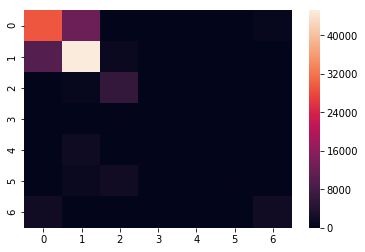

In [31]:
sb.heatmap(confusion_matrix(Y_test, Y_predslr));

In [25]:
# Classification by DecisionTreeClassifier (warning - takes a few minutes)
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
Y_predsdt = clf.predict(X_test)
# Confusion matrix
confusion_matrix(Y_test, Y_predsdt)

array([[38973,  3252,     1,     0,    58,     9,   223],
       [ 3150, 52711,   201,     1,   302,   149,    48],
       [    2,   197,  6444,    60,    12,   341,     0],
       [    0,     2,    70,   438,     0,    12,     0],
       [   40,   308,    16,     0,  1542,     7,     0],
       [   10,   151,   340,    15,     8,  2942,     0],
       [  259,    34,     0,     0,     0,     0,  3875]])

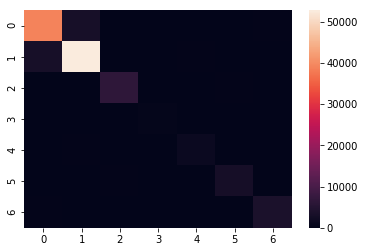

In [30]:
sb.heatmap(confusion_matrix(Y_test, Y_predsdt))

In [27]:
# Classification by Random forest (warning - takes a few minutes)
clf = RandomForestClassifier(n_estimators = 100, min_samples_split = 2)
clf.fit(X_train, Y_train)
Y_predsrf = clf.predict(X_test)
# Confusion matrix
confusion_matrix(Y_test, Y_predsrf)

array([[39244,  3140,     1,     0,    20,     5,   106],
       [ 1886, 54347,   116,     1,    95,   103,    14],
       [    1,   136,  6685,    33,     3,   198,     0],
       [    0,     0,    64,   444,     0,    14,     0],
       [   27,   429,    20,     0,  1426,    11,     0],
       [    2,   135,   348,    12,     3,  2966,     0],
       [  255,    21,     0,     0,     0,     0,  3892]])

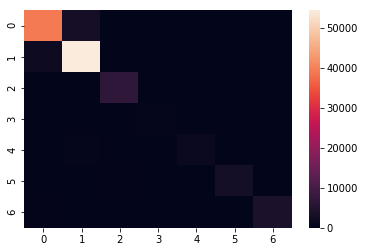

In [28]:
sb.heatmap(confusion_matrix(Y_test, Y_predsrf));

In [29]:
# Metrics analysis - Accuracy
ARlr = accuracy_score(Y_test, Y_predslr)
ARdt = accuracy_score(Y_test, Y_predsdt)
ARrf = accuracy_score(Y_test, Y_predsrf)
print("Accuracy score with Logistic regression: {:.4f}".format(ARlr))
print("Accuracy score with Decision Tree: {:.4f}".format(ARdt))
print("Accuracy score with Random forest: {:.4f}".format(ARrf))

Accuracy score with Logistic regression: 0.7135
Accuracy score with Decision Tree: 0.9202
Accuracy score with Random forest: 0.9380


## Summary

#### Source of the data: 
The UCI machine learning repository (url: https://archive.ics.uci.edu/ml/datasets/Covertype). <br>
Original sources:
Original owners of database: Remote Sensing and GIS Program, Department of Forest Sciences, College of Natural Resources, Colorado State University, Fort Collins, CO 80523 (contact Jock A. Blackard, jblackard 'at' fs.fed.us or Dr. Denis J. Dean, denis.dean 'at' utdallas.edu) 
<br>
#### Introduction: 
The data for forest cover type determination was downloaded from the url (https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz). The data was comprised of cartographic variables, derived from data originally obtained from US Geological Survey (USGS) and USFS data. The actual cover type for each observation was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data.
<br>

Initially, there were 581012 rows and 55 columns. The columns represented the the following attributes: Elevation (meters), Aspect (azimuth), Slope (degrees), Horizontal_Distance_To_Hydrology (meters), Vertical_Distance_To_Hydrology (meters), Horizontal_Distance_To_Roadways (meters), Hillshade_9am (0 to 255 index), Hillshade_Noon (0 to 255 index), Hillshade_3pm (0 to 255 index), Horizontal_Distance_To_Fire_Points (meters), Wilderness_Area (4 binary columns), Soil_Type (40 binary columns), Cover_Type (7 types).

The task is to build a predictive machine learning model that can reliably predict the forest cover type from the provided cartographic variables. For optimizing the classifier model, the attribute 'Cover_Type', represents the muticlass forest cover type classification.
<br>

#### Data wrangling and analyses
After checking the loaded dataframe, it was seen that there were 55 attributes. Of the 55, 4 were binary columns for the type of wilderness area. 40 columns denoted the binary variables for the soil type attribute.  <br>

The summary statistics indicated that some attributes followed a more or less normal distribution like the 'elevation' and 'hillshade at 3pm', while some others followed skewed distributions like 'horizontal distance to hydrology' and 'horizontal distance to roadways'. These were confirmed by plotting histograms and q-q plots. <br>

The cover types 1 and 2 seem most common, having 200,000 - 300,000 entries, while the rest (3-7) classes were constituted by less than 5000 instances each. Elevation seems to be a good variable at aiding classification of the cover types into groups, with some amount of overlaps between the classes. <br>

The numerical attributes, hillshade_9am, 'vdist_to_hydro' and 'hdist_to_road' were binned by equal width binning, and the obsolete non-binned columns deleted. All 54 attributes were used for modeling. 

#### Classification by supervised learning
The instances were split into training and test (20%) sets and subjected to supervised learning. I used LogisticRegression, DecisionTreeClassifier and RandomForestClassifier from the scikit-learn package to model and predict the multiclasses. Upon analysis of the confusion matrix and metrics, it was seen that the accuracies of the classifiers were 71%, 92% and 94% for the logistic regression, decision tree and random forest classifications. Higher accuracy rates may be attained by more optimization of the hyper-parameters for each of the models (e.g. non-linear solver for logistic regression). 